## colab settings

In [ ]:
import os

prj_name = 'cifar-10'
prj_path = '/content/drive/My Drive/colab/study/image_classification/'\
        + prj_name + '/'
os.chdir(prj_path + 'notebooks/')

## settings

In [ ]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

# main

In [ ]:
import torch
import torch.nn as nn

## load data

In [ ]:
from src.data.make_dataset import Cifar10BatchDataset

dpath = '../data/raw/'

train_folds = []
for i in range(1, 6):
    train_folds.append(torch.load(dpath + 'data_batch_' + str(i) + '.pt'))
test_set = torch.load(dpath + 'test_batch.pt')

In [ ]:
from collections import Counter

for train_fold in train_folds:
    print(sorted(Counter(s['label'] for s in train_fold).items()))
print(sorted(Counter(s['label'] for s in test_set).items()))

[(0, 1005), (1, 974), (2, 1032), (3, 1016), (4, 999), (5, 937), (6, 1030), (7, 1001), (8, 1025), (9, 981)]
[(0, 984), (1, 1007), (2, 1010), (3, 995), (4, 1010), (5, 988), (6, 1008), (7, 1026), (8, 987), (9, 985)]
[(0, 994), (1, 1042), (2, 965), (3, 997), (4, 990), (5, 1029), (6, 978), (7, 1015), (8, 961), (9, 1029)]
[(0, 1003), (1, 963), (2, 1041), (3, 976), (4, 1004), (5, 1021), (6, 1004), (7, 981), (8, 1024), (9, 983)]
[(0, 1014), (1, 1014), (2, 952), (3, 1016), (4, 997), (5, 1025), (6, 980), (7, 977), (8, 1003), (9, 1022)]
[(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


In [ ]:
from torch.utils.data import ConcatDataset, DataLoader

train_set = ConcatDataset([f for j, f in enumerate(train_folds) if j != 4])
val_set = train_folds[4]
train_loader = DataLoader(train_set, batch_size=5000,
        shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=5000,
        shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5000,
        shuffle=True, num_workers=2)

## model construction

In [ ]:
model_mpath = 'src.models.vgg'
model_name = 'VGG'
model_cfg = [[64], [128], [256, 256], [512, 512], [512, 512]]

In [ ]:
from importlib import import_module

model_cls = getattr(
        import_module(model_mpath),
        model_name
        )
model = model_cls(model_cfg)
for b in model.named_children():
    print(b)

('B_000', VGGConvBlock(
  (B_000): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B_001): ReLU(inplace=True)
  (B_002): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
))
('B_001', VGGConvBlock(
  (B_000): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B_001): ReLU(inplace=True)
  (B_002): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
))
('B_002', VGGConvBlock(
  (B_000): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B_001): ReLU(inplace=True)
  (B_002): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B_003): ReLU(inplace=True)
  (B_004): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
))
('B_003', VGGConvBlock(
  (B_000): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B_001): ReLU(inplace=True)
  (B_002): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B_003): ReLU(i

## train

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 174kB 7.0MB/s 


In [ ]:
from torch.optim import Adam
from src.models.train_model import train_net
import matplotlib.pyplot as plt

opt = Adam(model.parameters(), lr=0.00003)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda:0'

trainer = train_net(model, opt, loss_fn, train_loader, val_loader, device)
trainer.run(train_loader, max_epochs=1000)

Epoch 1
Train - Avg accuracy: 0.85 Avg loss: 0.45
Val   - Avg accuracy: 0.61 Avg loss: 2.36
Epoch 2
Train - Avg accuracy: 0.90 Avg loss: 0.26
Val   - Avg accuracy: 0.62 Avg loss: 2.12
Epoch 3
Train - Avg accuracy: 0.96 Avg loss: 0.13
Val   - Avg accuracy: 0.64 Avg loss: 1.99
Epoch 4
Train - Avg accuracy: 0.98 Avg loss: 0.08
Val   - Avg accuracy: 0.65 Avg loss: 1.87
Epoch 5
Train - Avg accuracy: 0.99 Avg loss: 0.06
Val   - Avg accuracy: 0.65 Avg loss: 1.88
Epoch 6
Train - Avg accuracy: 0.99 Avg loss: 0.05
Val   - Avg accuracy: 0.65 Avg loss: 1.87
Epoch 7
Train - Avg accuracy: 0.99 Avg loss: 0.04
Val   - Avg accuracy: 0.66 Avg loss: 1.88
Epoch 8
Train - Avg accuracy: 0.99 Avg loss: 0.04
Val   - Avg accuracy: 0.65 Avg loss: 1.90
Epoch 9
Train - Avg accuracy: 0.99 Avg loss: 0.04
Val   - Avg accuracy: 0.65 Avg loss: 1.92
Epoch 10
Train - Avg accuracy: 0.99 Avg loss: 0.04
Val   - Avg accuracy: 0.65 Avg loss: 1.93
Epoch 11
Train - Avg accuracy: 1.00 Avg loss: 0.04
Val   - Avg accuracy: 0.65 A

## Test

In [ ]:
from src.models.vgg import VGG

vgg11_cfg = [[64], [128], [256, 256], [512, 512], [512, 512]]
vgg11 = VGG(vgg11_cfg)
for b in vgg11.named_children():
    print(b)

1:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.10, v: 0.10


2:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.10, v: 0.10


3:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.10, v: 0.10


4:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.12, v: 0.15


5:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.11, v: 0.12


6:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.13, v: 0.14


7:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.14, v: 0.15


8:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.15, v: 0.15


9:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.16, v: 0.18


10:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.17, v: 0.19


11:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.18, v: 0.19


12:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.19, v: 0.21


13:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.17, v: 0.18


14:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.18, v: 0.19


15:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.16, v: 0.19


16:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.19, v: 0.20


17:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.20, v: 0.21


18:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.21, v: 0.22


19:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.21, v: 0.22


20:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.21, v: 0.20


21:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.20, v: 0.21


22:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.20, v: 0.20


23:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.21, v: 0.22


24:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.22, v: 0.22


25:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.22, v: 0.24


26:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.23, v: 0.24


27:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.24, v: 0.24


28:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.25, v: 0.25


29:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.26


30:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.27


31:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.27, v: 0.27


32:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.26


33:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.26


34:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.26, v: 0.28


35:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.28, v: 0.30


36:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.29, v: 0.30


37:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.30, v: 0.29


38:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.29, v: 0.27


39:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.29, v: 0.31


40:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.30, v: 0.31


41:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.31, v: 0.31


42:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.31, v: 0.31


43:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.32, v: 0.33


44:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.33, v: 0.34


45:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.34, v: 0.35


46:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.34, v: 0.35


47:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.34, v: 0.35


48:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.34, v: 0.35


49:   0%|          | 0/8 [00:00<?, ?it/s]

t: 0.35, v: 0.37


49: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


t: 0.35, v: 0.37


ValueError: ignored

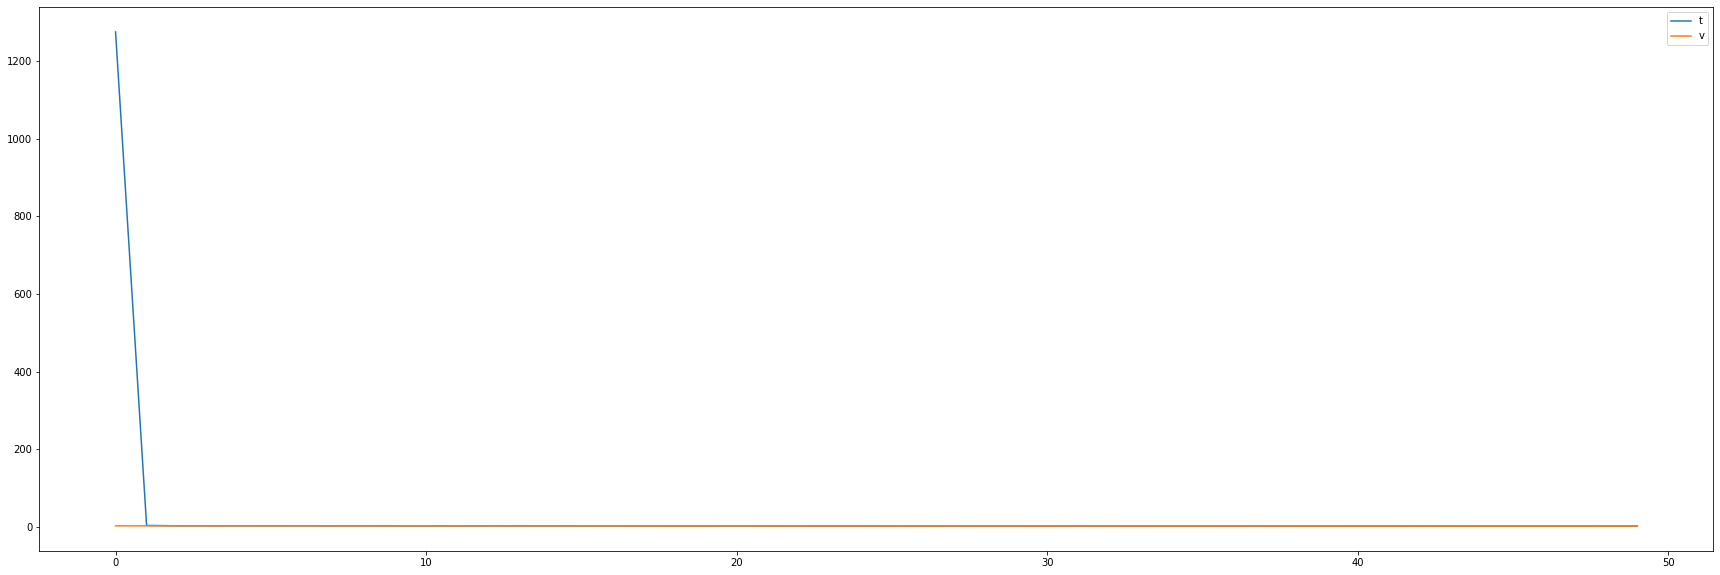

In [ ]:
# 수동으로 다 짜는 뻘짓이였다.

from src.models.train_model import train_net

from torch.utils.data import ConcatDataset, DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

loss_fn = nn.CrossEntropyLoss()
device = 'cuda:0'

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(30, 10))
test_loader = DataLoader(test_set, batch_size=64,
        shuffle=True, num_workers=2)
fold_models = []
for i in range(5):
    # ====================random state, vgg11 copy for each fold
    train_set = ConcatDataset([f for j, f in enumerate(train_folds) if j != i])
    val_set = train_folds[i]
    train_loader = DataLoader(train_set, batch_size=5000,
            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=5000,
            shuffle=True, num_workers=2)

    opt = Adam(vgg11.parameters(), lr=0.03)
    tl, ta, vl, va = train_net(vgg11, opt, loss_fn, 50,
            train_loader, val_loader, device, ax)

    break

In [ ]:
import torch
import torch.nn.functional as F
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(input, target)
loss.backward()

In [ ]:
input

tensor([[ 1.3824, -0.9514, -0.5539, -1.1105, -0.6623],
        [ 0.4279,  0.1307,  2.1382,  1.0987, -0.8870],
        [ 2.0576, -1.8201, -1.3227,  0.3146, -0.8222]], requires_grad=True)

In [ ]:
target

tensor([2, 0, 1])

In [ ]:
loss

tensor(2.8968, grad_fn=<NllLossBackward>)

In [ ]:
from itertools import repeat

class Sampyo(nn.Module):
    def __init__(self):
        super(Sampyo, self).__init__()
        self.layers = [nn.Linear(2, 2), nn.Linear(2, 2), nn.Linear(2, 2)]
        for i, m in enumerate(self.layers):
            self.add_module(m.__class__.__name__ + str(i), m)
        self.layman = nn.Linear(2, 2)



In [ ]:
sampyo = Sampyo()
for i, m in enumerate(sampyo.named_modules()):
    print(i, m)
print('==========================================')
for i, m in enumerate(sampyo.named_children()):
    print(i, m)
print('==========================================')
for i, m in enumerate(
            sampyo._named_members((lambda m: zip(repeat(''), m.layers)),
                    recurse=False)):
    print(i, m)

0 ('', Sampyo(
  (layman): Linear(in_features=2, out_features=2, bias=True)
))
1 ('layman', Linear(in_features=2, out_features=2, bias=True))
0 ('layman', Linear(in_features=2, out_features=2, bias=True))
0 ('', Linear(in_features=2, out_features=2, bias=True))
1 ('', Linear(in_features=2, out_features=2, bias=True))
2 ('', Linear(in_features=2, out_features=2, bias=True))


In [ ]:
sampyo = Sampyo()
for i, m in enumerate(sampyo.named_modules()):
    print(i, m)
print('==========================================')
for i, m in enumerate(sampyo.named_children()):
    print(i, m)
print('==========================================')
for i, m in enumerate(
            sampyo._named_members((lambda m: zip(repeat(''), m.layers)),
                    recurse=False)):
    print(i, m)

0 ('', Sampyo(
  (Linear0): Linear(in_features=2, out_features=2, bias=True)
  (Linear1): Linear(in_features=2, out_features=2, bias=True)
  (Linear2): Linear(in_features=2, out_features=2, bias=True)
  (layman): Linear(in_features=2, out_features=2, bias=True)
))
1 ('Linear0', Linear(in_features=2, out_features=2, bias=True))
2 ('Linear1', Linear(in_features=2, out_features=2, bias=True))
3 ('Linear2', Linear(in_features=2, out_features=2, bias=True))
4 ('layman', Linear(in_features=2, out_features=2, bias=True))
0 ('Linear0', Linear(in_features=2, out_features=2, bias=True))
1 ('Linear1', Linear(in_features=2, out_features=2, bias=True))
2 ('Linear2', Linear(in_features=2, out_features=2, bias=True))
3 ('layman', Linear(in_features=2, out_features=2, bias=True))
0 ('', Linear(in_features=2, out_features=2, bias=True))
1 ('', Linear(in_features=2, out_features=2, bias=True))
2 ('', Linear(in_features=2, out_features=2, bias=True))
